In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ! pip install torchxrayvision
# ! pip install pgmpy
# ! pip install kaggle
# !pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [31]:
import torch
import torchxrayvision as xrv
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# ============================
# 1️⃣ Load Pretrained DenseNet-121 Model
# ============================
model = xrv.models.DenseNet(weights="densenet121-res224-all")
model.eval()  # Set model to evaluation mode

# Define Preprocessing for Input Images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),  # Resize for model
    transforms.ToTensor()
])

# Get list of diseases the model can predict
pathology_labels = xrv.datasets.default_pathologies


# ============================
# 2️⃣ Function to Extract Features & Disease Probabilities
# ============================
def extract_features(image_path):
    """Extract features and disease probabilities from an X-ray."""
    image = Image.open(image_path).convert("L")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        preds = model(image_tensor)  # Get disease probabilities
        features = model.features(image_tensor)  # Extract feature vector
        features = torch.flatten(features, start_dim=1)  # Flatten to 1D

    # Convert disease probabilities to a dictionary
    predicted_diseases = {pathology_labels[i]: preds[0, i].item() for i in range(len(pathology_labels))}

    return features.numpy(), predicted_diseases

In [35]:
import os

def list_files(directory):
  try:
    return os.listdir(directory)
  except FileNotFoundError:
    return []

# Configuration
image_dir = "/content/drive/MyDrive/kaggle/images_001/images/"

# Load and preprocess images
image_files = list_files(image_dir)

# Load and preprocess labels
data_entry = pd.read_csv("/content/drive/MyDrive/kaggle/Data_Entry_2017.csv")
img_files = data_entry[data_entry['Image Index'].isin(image_files)]
img_files = img_files[['Image Index', 'Finding Labels', 'Patient Age', 'Patient Gender']].reset_index(drop=True)

# Process labels
separated_labels = [labels.split('|') for labels in img_files['Finding Labels']]
all_labels = set([label for labels_list in separated_labels for label in labels_list])
for label in all_labels:
    img_files[label] = 0
for index, row in img_files.iterrows():
    for label in separated_labels[index]:
      img_files.loc[index, label] = 1
img_files = img_files.drop('Finding Labels', axis=1)
img_files.set_index('Image Index', inplace=True)
img_files

,Patient Age,Patient Gender,No Finding,Nodule,Edema,Pleural_Thickening,Consolidation,Emphysema,Mass,Hernia,Infiltration,Effusion,Cardiomegaly,Fibrosis,Pneumonia,Pneumothorax,Atelectasis
Image Index,,,,,,,,,,,,,,,,,
00000001_000.png,58,M,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
00000001_001.png,58,M,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
00000001_002.png,58,M,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
00000002_000.png,81,M,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00000003_000.png,81,F,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00001335_002.png,18,F,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00001335_003.png,19,F,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00001335_004.png,19,F,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# prompt: train_test_split img_files

from sklearn.model_selection import train_test_split

# Assuming img_files is the DataFrame you created in the previous code
train, test = train_test_split(img_files, test_size=0.2, random_state=42) # Adjust test_size as needed

print("Training set size:", len(train))
print("Testing set size:", len(test))

Training set size: 3999
Testing set size: 1000


Building tree:   0%|          | 0/136.0 [00:00<?, ?it/s]

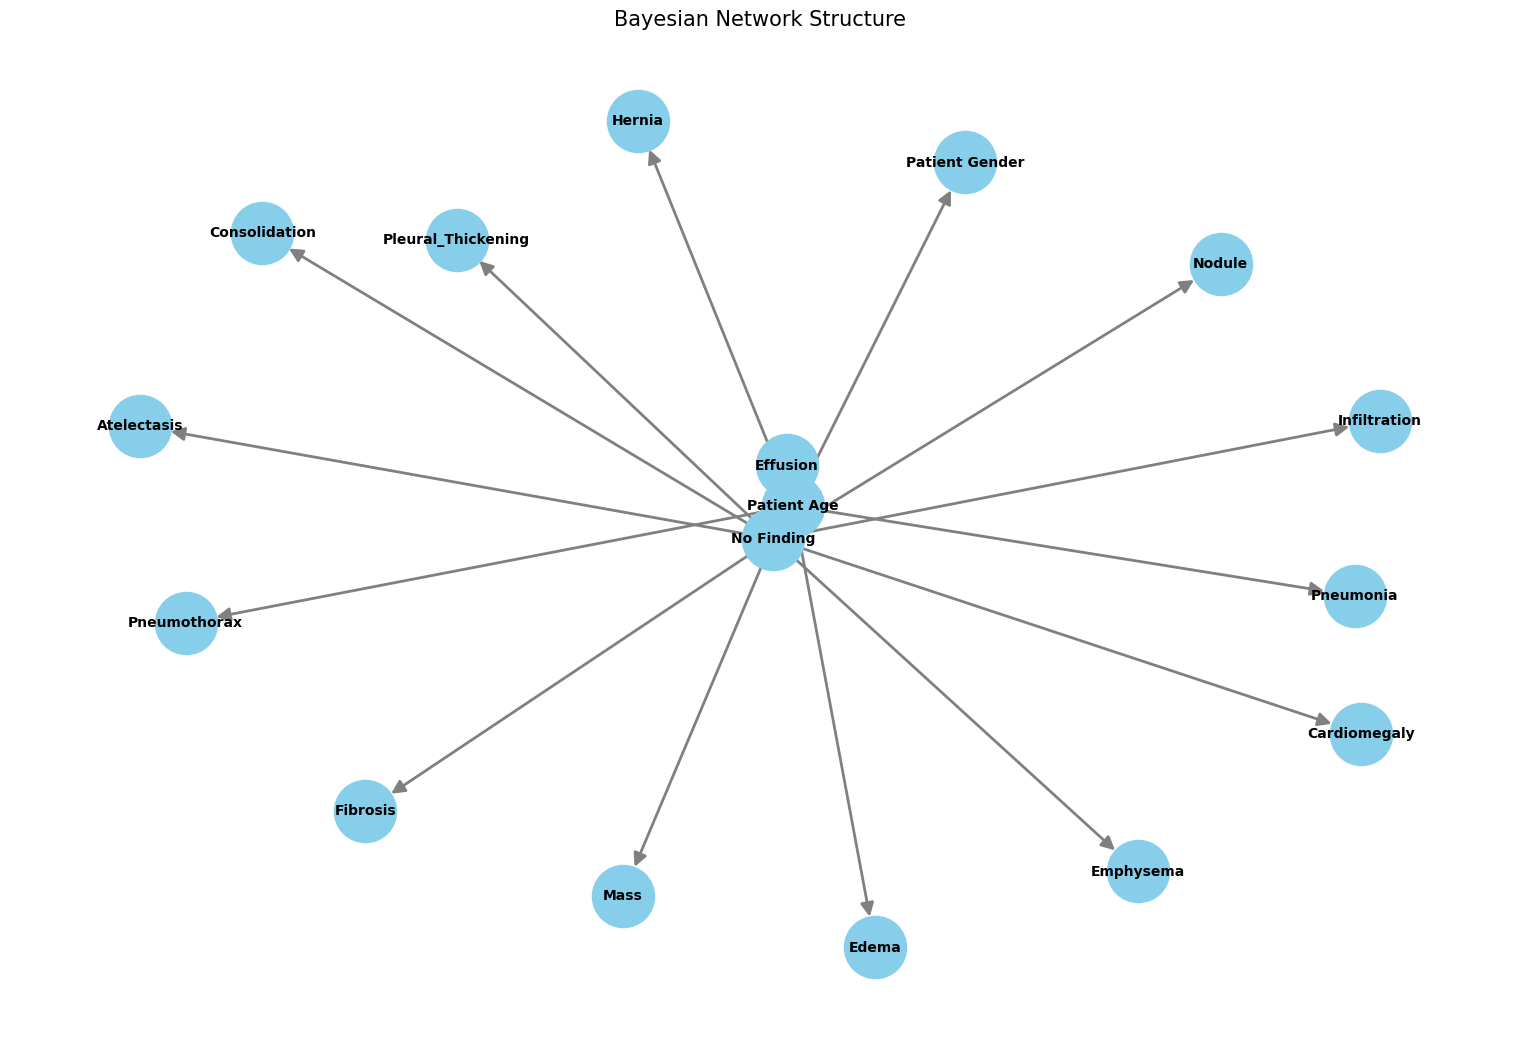

In [51]:
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, PC, TreeSearch, BicScore
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt


est_tree = TreeSearch(train)
best_tree_model = est_tree.estimate()

network_tree = BayesianNetwork(best_tree_model)
mle = MaximumLikelihoodEstimator(network_tree, train)

for cpd in mle.get_parameters():
    network_tree.add_cpds(cpd)

# Visualize the Bayesian network structure
G = nx.DiGraph()
G.add_nodes_from(network_tree.nodes())
G.add_edges_from(network_tree.edges())

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20, edge_color="gray", width=2)
plt.title("Bayesian Network Structure", fontsize=15)
plt.tight_layout()
plt.show()

In [68]:
file_dir = "/content/drive/MyDrive/kaggle/images_001/images/"
file_dir + test.index[0]
patient_age = test.loc[test.index[0]]['Patient Age']
patient_gender = test.loc[test.index[0]]['Patient Gender']
features, preds = extract_features(file_dir + test.index[0])

binary_preds = {}
for disease, probability in preds.items():
    binary_preds[disease] = 1 if probability > 0.5 else 0

# Perform Bayesian Inference
infer = VariableElimination(network_tree)  # Use network_tree instead of bayesian_net

# Construct the evidence dictionary dynamically
evidence = {
    "Patient Age": patient_age,
    "Patient Gender": patient_gender,
            }
evidence.update({disease: value for disease, value in binary_preds.items() if disease in network_tree.nodes()})

# Get a list of all nodes in the network
all_nodes = network_tree.nodes()

# Separate nodes into variables to query and evidence
evidence_nodes = list(evidence.keys())  # Nodes used as evidence
query_nodes = [node for node in all_nodes if node not in evidence_nodes]  # Nodes to infer

# Predict probabilities
result = infer.query(variables=query_nodes, evidence=evidence)
print(result)

+---------------+-------------------+
| No Finding    |   phi(No Finding) |
+===============+===================+
| No Finding(0) |            1.0000 |
+---------------+-------------------+
| No Finding(1) |            0.0000 |
+---------------+-------------------+


In [71]:
pathology_labels

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']